In [1]:
# Third-party and Standard Libraries
from datetime import datetime
import numpy as np
import torch
import time
import os
import matplotlib.pyplot as plt
# Modules
from KG_test import gpt_test, gpt_test_loss, pinn_test, pinn_test_loss,gpt_test_bic,gpt_test_loss_bic
from KG_precompute import inputs, gram_schmidt1, gram_schmidt2
from KG_train import pinn_train, offline_generation_bic, offline_generation, offline_generation_bic_full
from KG_data import residual_data, ICBC_data
from KG_precompute import xcos_term
from KG_models import NN

data_dir = "./kg_data"
if (os.path.exists(data_dir) == False):
    os.makedirs(data_dir)

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda")
print_seperator = 60*"*"

sparse = True

if (sparse):
    ext = "bic_s"
else:
    ext = ""

print(f"Start: {datetime.now()}\n")

###############################################################################
#### Domain and simulated data ####
Xi, Xf         = -1.0, 1.0
Ti, Tf         =  0.0, 5.0
Nc, N_test     =  100,  40
BC_pts, IC_pts =  512, 512

xt_resid, f_hat, xt_test = residual_data(Xi, Xf, Ti, Tf, Nc, N_test)
xt_resid = xt_resid.to(device)
f_hat    = f_hat.to(device)
xt_test  = xt_test.to(device) 

IC_xt, IC_u1, IC_u2, BC_xt, BC_u = ICBC_data(Xi, Xf, Ti, Tf, BC_pts, IC_pts) 
IC_xt = IC_xt.to(device)
IC_u1 = IC_u1.to(device)
IC_u2 = IC_u2.to(device)
BC_xt = BC_xt.to(device)
BC_u  = BC_u.to(device)    

#### Training parameter set ####
alpha    = np.linspace(-2, -1, 10)
beta     = np.linspace( 0,  1, 10)
gamma    = np.linspace( 0,  1, 10) 
kg_train = np.array(np.meshgrid(alpha, beta, gamma)).T.reshape(-1,3)
kg_train_all = kg_train.copy() 

#### Forcing function ####
xcos_x2cos2 = xcos_term(xt_resid[:,0].unsqueeze(1), 
                        xt_resid[:,1].unsqueeze(1))

#### PINN Attributes ####
layers_pinn = np.array([2, 40, 40, 1])
lr_pinn     = 0.0005
epochs_pinn = 20000#100000

#### GPT-PINN attributes ####
number_of_neurons = 12
if (sparse):
    lr_gpt = 0.0025
else:
    lr_gpt = 0.025
epochs_gpt_train  = 2000

test_cases      = np.ceil(0.2*len(kg_train)).astype(int)
epochs_gpt_test = 5000

loss_list  = np.zeros(number_of_neurons)
loss_list_full_grid  = np.zeros(number_of_neurons)
neurons    = np.zeros((number_of_neurons,3))

# Two kinds of initializations for the neurons
neurons[0] = (np.median(alpha), np.median(beta), np.median(gamma))
#neurond[0] = kg_train[np.random.randint(low=0, high=len(kg_train))]

c_init = np.zeros(number_of_neurons, dtype=object)
for i in range(number_of_neurons):
    c_init[i] = torch.full((1,i+1), 1/(i+1)).to(device)

#### Data sizes ####
test_size = xt_test.shape[0]
xt_size   = xt_resid.shape[0]
IC_size   = IC_xt.shape[0]
BC_size   = BC_xt.shape[0]

if (sparse):
    #### Training point data ####
    X_train_all   = torch.zeros((2*number_of_neurons-1,2)).to(device)
    X_all_idx     = torch.zeros( 2*number_of_neurons-1, dtype=torch.long).to(device)
    X_umax_idx    = torch.zeros(   number_of_neurons,   dtype=torch.long).to(device)
    X_rmax_idx    = torch.zeros(   number_of_neurons-1, dtype=torch.long).to(device)
    residual_full = torch.zeros((xt_size, number_of_neurons-1)).to(device)

#### Neuron outputs on the full training grid ####
xt_resid      = xt_resid.requires_grad_()
IC_xt         = IC_xt.requires_grad_()
out_full      = torch.zeros((xt_size, number_of_neurons)).to(device) 
out_xx_full   = torch.zeros((xt_size, number_of_neurons)).to(device) 
out_tt_full   = torch.zeros((xt_size, number_of_neurons)).to(device) 
out_BC        = torch.zeros((BC_size, number_of_neurons)).to(device)
out_IC        = torch.zeros((IC_size, number_of_neurons)).to(device)
out_IC_t      = torch.zeros((IC_size, number_of_neurons)).to(device)

#### Neuron outputs on the test grid ####
out_test = torch.zeros((test_size, number_of_neurons)).to(device) 
L_hat = torch.zeros(number_of_neurons,1).to(device)

Start: 2024-12-31 07:02:49.752070



************************************************************


/dssg/home/acct-matxzl/matxzl/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


PINN Final Loss: 9.951195534085855e-05
PINN time: 1.212548017501831 minutes

tensor(1.6146, device='cuda:0')
Generation time: 0.40743409395217894 minutes


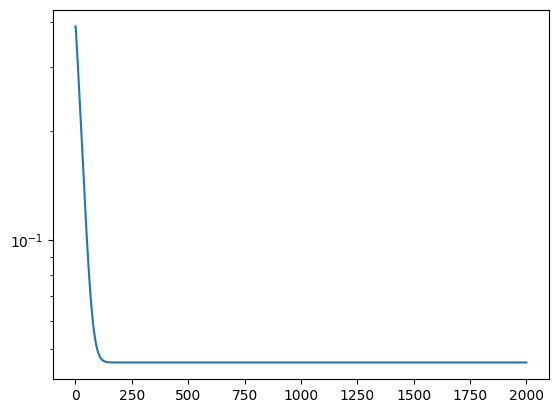


Largest Loss (Using 1 Neurons): 1.2110013961791992

Largest Loss full grid (Using 1 Neurons): 0.22227439284324646
Parameter Case: (-1.0, 1.0, 0.0)

************************************************************
PINN Final Loss: 0.0001501579099567607
PINN time: 1.2026853720347086 minutes

tensor(1.0103, device='cuda:0')
Generation time: 0.4190589427947998 minutes


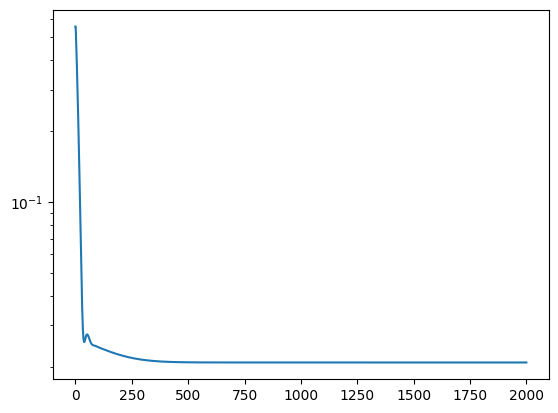


Largest Loss (Using 2 Neurons): 0.044709980487823486

Largest Loss full grid (Using 2 Neurons): 0.10614781081676483
Parameter Case: (-2.0, 1.0, 0.0)

************************************************************
PINN Final Loss: 0.0006728030857630074
PINN time: 1.210349404811859 minutes

tensor(0.9157, device='cuda:0')
Generation time: 0.9309627374013265 minutes


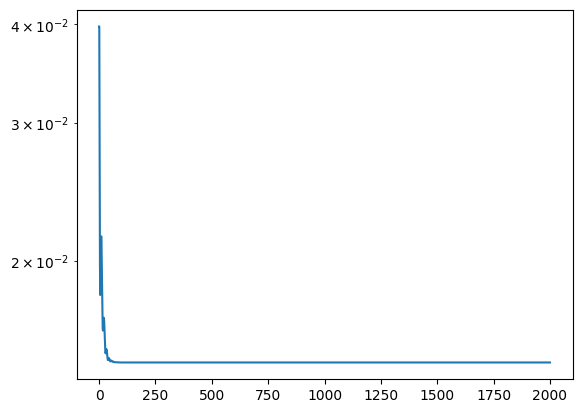


Largest Loss (Using 3 Neurons): 0.037568479776382446

Largest Loss full grid (Using 3 Neurons): 0.05865592136979103
Parameter Case: (-1.0, 0.0, 1.0)

************************************************************
PINN Final Loss: 2.6640002033673227e-05
PINN time: 1.2965416391690572 minutes

tensor(0.9512, device='cuda:0')
Generation time: 2.5007129589716595 minutes


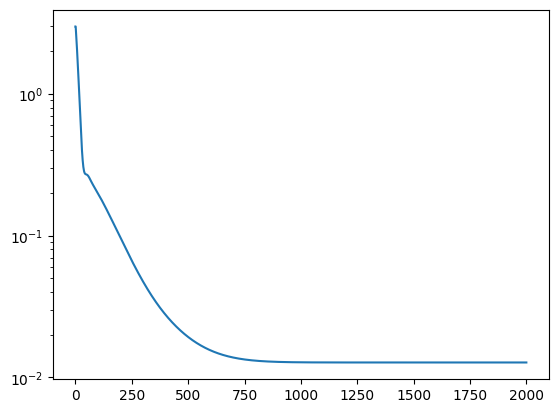


Largest Loss (Using 4 Neurons): 0.021956901997327805

Largest Loss full grid (Using 4 Neurons): 0.7596796751022339
Parameter Case: (-2.0, 0.0, 1.0)

************************************************************
PINN Final Loss: 4.816673754248768e-05
PINN time: 1.2955408811569213 minutes

tensor(0.9330, device='cuda:0')
Generation time: 1.0603100498517355 minutes


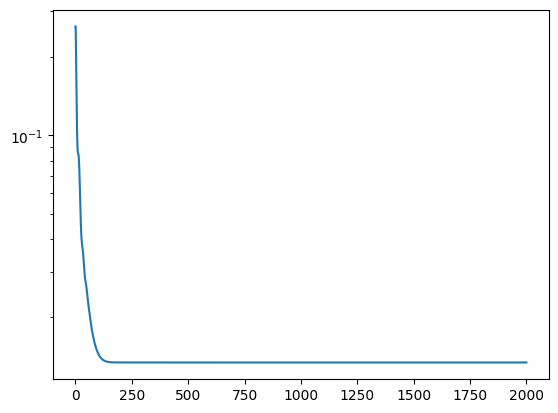


Largest Loss (Using 5 Neurons): 0.07147765904664993

Largest Loss full grid (Using 5 Neurons): 0.07815707474946976
Parameter Case: (-1.0, 0.0, 0.0)

************************************************************
PINN Final Loss: 8.461320248898119e-05
PINN time: 1.2971291621526082 minutes

tensor(0.9853, device='cuda:0')
Generation time: 2.383958303928375 minutes


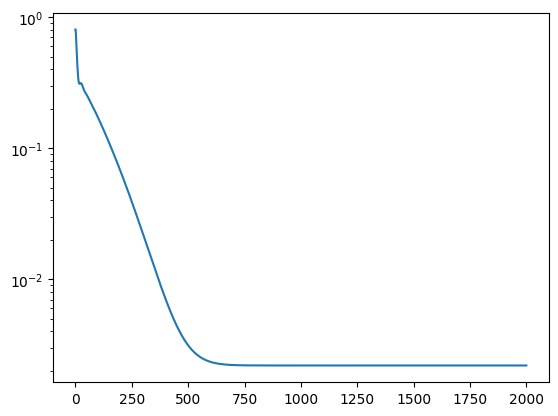


Largest Loss (Using 6 Neurons): 0.007339722942560911

Largest Loss full grid (Using 6 Neurons): 0.6751419305801392
Parameter Case: (-2.0, 1.0, 1.0)

************************************************************
PINN Final Loss: 0.00020552921341732144
PINN time: 1.295691398779551 minutes

tensor(0.9934, device='cuda:0')
Generation time: 1.9622290889422098 minutes


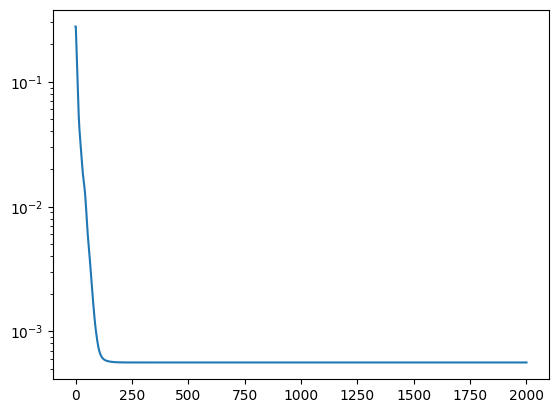


Largest Loss (Using 7 Neurons): 0.003925784025341272

Largest Loss full grid (Using 7 Neurons): 0.4233142137527466
Parameter Case: (-1.3333333333333335, 0.0, 0.0)

************************************************************
PINN Final Loss: 5.1045306463493034e-05
PINN time: 1.3019018451372781 minutes

tensor(0.9967, device='cuda:0')
Generation time: 3.2636228799819946 minutes


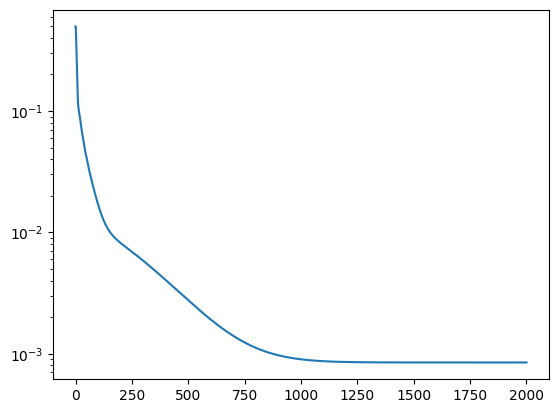


Largest Loss (Using 8 Neurons): 0.0026384193915873766

Largest Loss full grid (Using 8 Neurons): 0.9790689945220947
Parameter Case: (-1.8888888888888888, 0.0, 0.0)

************************************************************
PINN Final Loss: 3.866764382109977e-05
PINN time: 1.2957160631815592 minutes

tensor(1.0006, device='cuda:0')
Generation time: 3.046514622370402 minutes


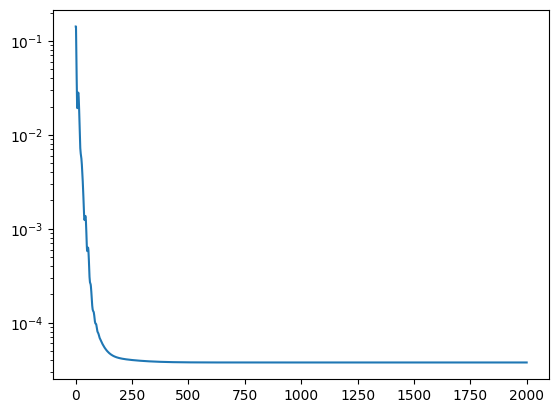


Largest Loss (Using 9 Neurons): 0.001651959726586938

Largest Loss full grid (Using 9 Neurons): 0.1354738473892212
Parameter Case: (-1.3333333333333335, 1.0, 0.0)

************************************************************
PINN Final Loss: 0.00023788970429450274
PINN time: 1.2997528791427613 minutes

tensor(0.9967, device='cuda:0')
Generation time: 5.296972143650055 minutes


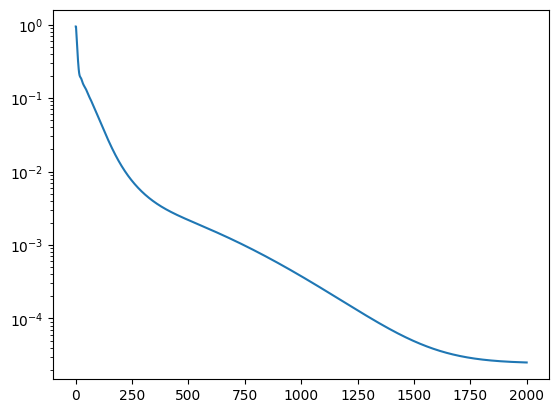


Largest Loss (Using 10 Neurons): 0.002109700348228216

Largest Loss full grid (Using 10 Neurons): 0.006525758653879166
Parameter Case: (-1.1111111111111112, 1.0, 1.0)

************************************************************
PINN Final Loss: 0.00030535177211277187
PINN time: 1.2968704581260682 minutes

tensor(0.9990, device='cuda:0')
Generation time: 7.509904952843984 minutes


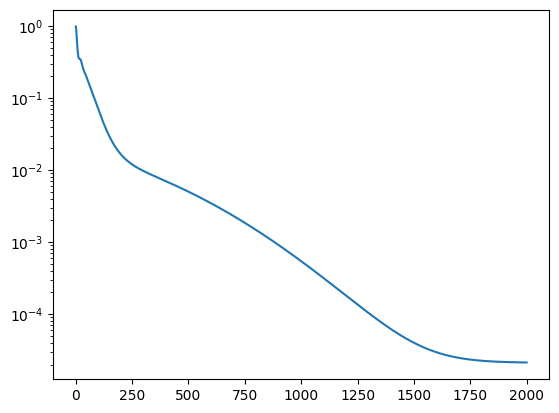


Largest Loss (Using 11 Neurons): 0.0003418121486902237

Largest Loss full grid (Using 11 Neurons): 0.4180434048175812
Parameter Case: (-1.4444444444444444, 0.0, 1.0)

************************************************************
PINN Final Loss: 3.4383985621389e-05
PINN time: 1.3037217219670614 minutes

tensor(1.0000, device='cuda:0')
Generation time: 8.491650080680847 minutes


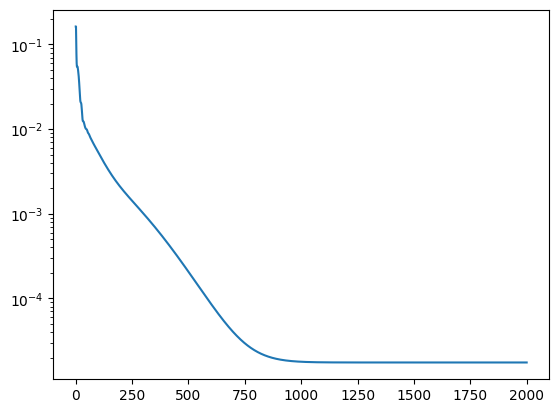


Largest Loss (Using 12 Neurons): 0.00014423942775465548

Largest Loss full grid (Using 12 Neurons): 0.37307271361351013
Parameter Case: (-1.6666666666666667, 1.0, 0.0)

************************************************************
Total Training Time: 0.8823652346928914 Hours

Activation Function Parameters: 
[[-1.5         0.5         0.5       ]
 [-1.          1.          0.        ]
 [-2.          1.          0.        ]
 [-1.          0.          1.        ]
 [-2.          0.          1.        ]
 [-1.          0.          0.        ]
 [-2.          1.          1.        ]
 [-1.33333333  0.          0.        ]
 [-1.88888889  0.          0.        ]
 [-1.33333333  1.          0.        ]
 [-1.11111111  1.          1.        ]
 [-1.44444444  0.          1.        ]]

Loss list: [1.21100140e+00 4.47099805e-02 3.75684798e-02 2.19569020e-02
 7.14776590e-02 7.33972294e-03 3.92578403e-03 2.63841939e-03
 1.65195973e-03 2.10970035e-03 3.41812149e-04 1.44239428e-04]



In [2]:
generation_time = np.zeros(number_of_neurons)

###############################################################################
total_time_1 = time.time()
for i, neuron in enumerate(neurons):
    print(print_seperator)
    
    # Don't need to train over parameters already used as neurons
    kg_train = np.delete(kg_train, np.where(np.all(kg_train == neuron, 
                                                   axis=1))[0], axis=0)
    ###########################################################################
    # PINN to be used as activation function  
    alpha, beta, gamma = neuron
    t1 = time.time()
    PINN = NN(layers_pinn, alpha, beta, gamma, xcos_x2cos2).to(device)
    pinn_train(PINN, alpha, beta, gamma, xt_resid, IC_xt, IC_u1, IC_u2, BC_xt, 
               BC_u, f_hat, epochs_pinn, lr_pinn)
    t2 = time.time()
    print(f"PINN time: {(t2-t1)/60} minutes\n")
    ###########################################################################
    # (S)GPT-PINN Training / Offline Generation    
    c_initial  = c_init[i][0]

    if (sparse): # SGPT
        train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, \
        train_out_BC, fhat, train_xcos, xt_len,ALPHA,Lhat = gram_schmidt1(PINN, i, xt_resid, 
        IC_xt, BC_xt, out_full, out_xx_full, out_tt_full, out_IC, out_IC_t, out_BC, 
        xcos_x2cos2, X_umax_idx, X_all_idx, X_train_all, xt_test, out_test, f_hat,L_hat)

        if i==0:
            c_ui = PINN(xt_resid)
            c_x_umax_idx = torch.argmax(torch.abs(c_ui))
            if c_ui[c_x_umax_idx]<0:
                c_initial[i] = -1.0
        else:
            c_initial[:i] = ALPHA.squeeze()
            c_initial[i] = 0.0        
        
    else: # GPT
        train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, \
        train_out_BC, fhat, train_xcos, xt_len = inputs(PINN, xt_resid, out_full, 
        out_xx_full, out_tt_full, out_IC_t, out_IC, out_BC, IC_xt, BC_xt, i, 
        out_test, xt_test, f_hat, xcos_x2cos2, xt_size)
    
    t1 = time.time()
    largest_loss, largest_case, trained_c,largest_loss0 = offline_generation_bic_full(kg_train, 
    c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, xcos_x2cos2,out_full[:,:i+1], out_xx_full[:,:i+1], out_tt_full[:,:i+1],train_out_IC, train_out_IC_t, 
    train_out_BC, fhat,f_hat, epochs_gpt_train, lr_gpt,Lhat)   
    print(sum(sum(Lhat*trained_c.view(-1,1))))                                                    
    t2 = time.time()
    
    generation_time[i] = (t2-t1)/60
    print(f"Generation time: {(t2-t1)/60} minutes")     
    
    kg_test1 = [[-2,0,0.44]]
    test_gpt_losses = gpt_test_loss_bic(kg_test1,c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt,Lhat)
    plt.plot(test_gpt_losses)
    plt.yscale('log')
    plt.show()                                                    
    ###########################################################################
    loss_list[i] = largest_loss
    loss_list_full_grid[i] = largest_loss0
    
    if (i+1 < number_of_neurons):
        neurons[i+1] = largest_case
        
    print(f"\nLargest Loss (Using {i+1} Neurons): {largest_loss}")
    print(f"\nLargest Loss full grid (Using {i+1} Neurons): {largest_loss0}")
    print(f"Parameter Case: {largest_case}\n")
        
    if (i == number_of_neurons-1):
        break
    
    ###########################################################################
    if (sparse):
        alpha, beta, gamma = largest_case
        gram_schmidt2(i, xt_resid, alpha, beta, gamma, trained_c, residual_full, 
                      out_full, out_xx_full, out_tt_full, xcos_x2cos2, X_rmax_idx, 
                      X_all_idx, X_train_all)
        
total_time = (time.time() - total_time_1) / 3600

print(print_seperator)
print(f"Total Training Time: {total_time} Hours\n")
print(f"Activation Function Parameters: \n{neurons}\n")
print(f"Loss list: {loss_list}\n")

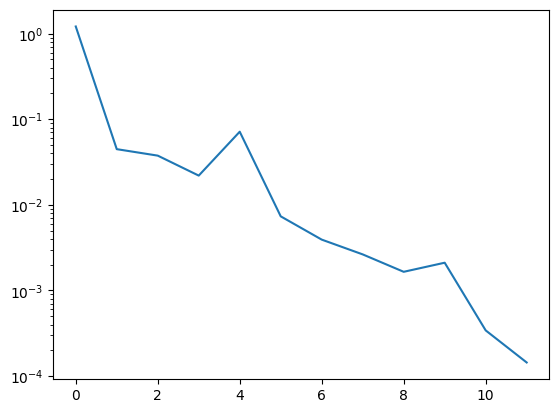

In [3]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.yscale('log')

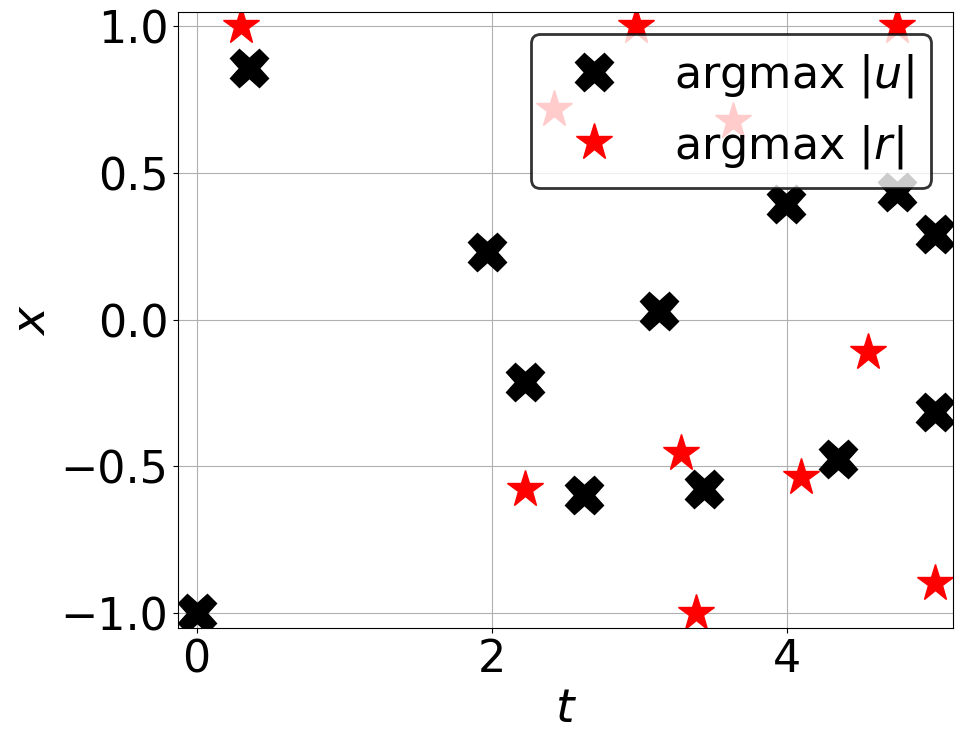

In [4]:
x_u = xt_resid[X_umax_idx,0].cpu().detach().numpy()
t_u = xt_resid[X_umax_idx,1].cpu().detach().numpy()

x_r = xt_resid[X_rmax_idx,0].cpu().detach().numpy()
t_r = xt_resid[X_rmax_idx,1].cpu().detach().numpy()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(t_u, x_u, "X", color="black", label="argmax $|u|$", markersize=28)
ax.plot(t_r, x_r, "*", color="red",   label="argmax $|r|$", markersize=28)
ax.set_xlim(0-0.125,5+0.125)
ax.set_xlabel("$t$", fontsize=34)
ax.set_ylim(-1-0.05,1+0.05)
ax.set_ylabel("$x$", fontsize=34)
legend = ax.legend(frameon=True, fontsize=32)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', which='major', labelsize=32)
ax.grid()
plt.show()

In [5]:
print({stop})

NameError: name 'stop' is not defined

In [6]:
#kg_test = kg_train[np.random.choice(len(kg_train), test_cases, replace=False)]
kg_test = np.loadtxt(data_dir + "/kg_test.dat")
pinn_test_soln = np.loadtxt(data_dir+"/test_pinn_soln.dat")

from KG_test import gpt_test_bic,gpt_test_loss_bic
print(f"{ext.upper()}GPT-PINN Testing Started")
test_gpt_time, test_gpt_soln = gpt_test_bic(kg_test,c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt,out_test,Lhat)

test_gpt_losses = gpt_test_loss_bic(kg_test,c_initial, xt_len, IC_size, BC_size, IC_u1, IC_u2, BC_u, train_xcos, 
    train_out, train_out_xx, train_out_tt, train_out_IC, train_out_IC_t, 
    train_out_BC, fhat, epochs_gpt_train, lr_gpt,Lhat)
print(f"{ext.upper()}GPT-PINN Testing Ended\n")

BIC_SGPT-PINN Testing Started
BIC_SGPT-PINN Testing Ended



In [11]:
np.savetxt(data_dir+f"/{ext}gpt_generation_time.dat",  generation_time)
np.savetxt(data_dir+f"/{ext}gpt_loss_list.dat",        loss_list)
np.savetxt(data_dir+f"/{ext}gpt_loss_list_full_grid.dat",        loss_list_full_grid)
np.savetxt(data_dir+f"/{ext}gpt_neurons.dat",          neurons)
np.savetxt(data_dir+f"/{ext}gpt_total_time.dat",       np.array([total_time]))

np.savetxt(data_dir+"/xt_resid.dat",         xt_resid.detach().cpu().numpy())
if (sparse):
    np.savetxt(data_dir+"/X_train_all.dat",  X_train_all.cpu().numpy())
    np.savetxt(data_dir+"/X_all_idx.dat",    X_all_idx.cpu().numpy())
    np.savetxt(data_dir+"/X_umax_idx.dat",   X_umax_idx.cpu().numpy())
    np.savetxt(data_dir+"/X_rmax_idx.dat",   X_rmax_idx.cpu().numpy())

np.savetxt(data_dir+"/kg_train_all.dat",     kg_train_all)
np.savetxt(data_dir+"/kg_test.dat",          kg_test)
np.savetxt(data_dir+"/xt_test.dat",          xt_test.cpu().numpy())

np.savetxt(data_dir+f"/test_{ext}gpt_losses.dat", test_gpt_losses)
np.savetxt(data_dir+f"/test_{ext}gpt_soln.dat",   test_gpt_soln)
np.savetxt(data_dir+f"/test_{ext}gpt_time.dat",   test_gpt_time+total_time)

#np.savetxt(data_dir+"/test_pinn_losses.dat", test_losses_pinn)
#np.savetxt(data_dir+"/test_pinn_soln.dat",   test_pinn_soln)
#np.savetxt(data_dir+"/test_pinn_time.dat",   test_pinn_time)

params = {"device":device,
          "domain": {"xi":Xi, "xf":Xf, "ti":Ti, "tf":Tf}, 
          "data sizes": {"Nc":Nc, "N_test":N_test, "BC_pts":BC_pts, "IC_pts":IC_pts},
          "layers pinn":layers_pinn,
          "lr pinn":lr_pinn,
          "epochs pinn":epochs_pinn,
          "parameter size":len(kg_train_all),
          "number of neurons":number_of_neurons,
          f"lr {ext}gpt":lr_gpt,
          f"epochs {ext}gpt train":epochs_gpt_train,
          "test cases":test_cases,
          f"epochs {ext}gpt test":epochs_gpt_test,
          "sparse":sparse,
          "seed":seed}

np.save(data_dir+"/params_sgpt_bic_adam.npy", params) 

FileNotFoundError: [Errno 2] No such file or directory: './kg_data/generation_time.dat'

In [10]:
variables = {
    "kg_test": kg_test,
    "c_initial": c_initial,
    "xt_len": xt_len,
    "IC_size": IC_size,
    "BC_size": BC_size,
    "IC_u1": IC_u1,
    "IC_u2": IC_u2,
    "BC_u": BC_u,
    "train_xcos": train_xcos,
    "train_out": train_out,
    "train_out_xx": train_out_xx,
    "train_out_tt": train_out_tt,
    "train_out_IC": train_out_IC,
    "train_out_IC_t": train_out_IC_t,
    "train_out_BC": train_out_BC,
    "fhat": fhat,
    "epochs_gpt_train": epochs_gpt_train,
    "lr_gpt": lr_gpt,
    "out_test": out_test,
    "Lhat": Lhat
}
torch.save(variables,data_dir+"/variables_sgpt_bic_adam.npy") 